In [1]:
import sys
print(sys.executable)
#/Users/ibhallaladd/Desktop/venv/bin/python
sys.path



/Users/ibhallaladd/Desktop/venv/bin/python


['/Users/ibhallaladd/Desktop',
 '/Users/ibhallaladd/.pyenv/versions/3.7.3/lib/python37.zip',
 '/Users/ibhallaladd/.pyenv/versions/3.7.3/lib/python3.7',
 '/Users/ibhallaladd/.pyenv/versions/3.7.3/lib/python3.7/lib-dynload',
 '',
 '/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages',
 '/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/IPython/extensions',
 '/Users/ibhallaladd/.ipython']

In [2]:
from __future__ import division # Force python to turn integer division into a float result! Otherwise your fake rates will be all 0...
%load_ext autoreload
%autoreload 2
import os
import sys
import argparse
import glob
import numpy as np
import uproot
import pandas as pd
import pickle
import tables
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy import integrate


plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 14
pd.options.mode.chained_assignment = None  # default='warn'. This eliminates warnings when assigning new variables to dataframes during the cutflow.
#sys.path.append('/project/hep/demers/mnp3/ATLAS/vhtautau/python')
#from cutflow_functions import *
#from preselection_cutflows import *
#from signal_cutflows import *

/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#from ROOT import TFile, TTree
#from ROOT import gROOT, AddressOf

In [4]:
# Grab a Ztautau sample with neutrino data saved
f = uproot.open("/Users/ibhallaladd/Desktop/hleptons_ztautau_lephad_mmc_test_file.root")
variables = [var.decode() for var in f["NOMINAL"].keys()] 
a = f["NOMINAL"].arrays(variables)

### New in Python3: decode bytestrings into actual strings, otherwise the strings won't be recognized below
def convert(data):
    if isinstance(data, bytes):  return data.decode()
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return tuple(map(convert, data))
    if isinstance(data, list):   return list(map(convert, data))
    return data
a = convert(a)

df = pd.DataFrame.from_dict(a)

In [5]:
vars = df.keys()
[var for var in vars if "tau_1" in var]

['tau_1',
 'tau_1_EL_CHARGEID_STAT_1down_EleEffSF_ChargeID_MediumLLH_d0z0_v13_FCLoose',
 'tau_1_EL_CHARGEID_STAT_1up_EleEffSF_ChargeID_MediumLLH_d0z0_v13_FCLoose',
 'tau_1_EL_CHARGEID_SYStotal_1down_EleEffSF_ChargeID_MediumLLH_d0z0_v13_FCLoose',
 'tau_1_EL_CHARGEID_SYStotal_1up_EleEffSF_ChargeID_MediumLLH_d0z0_v13_FCLoose',
 'tau_1_EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR_1down_EleEffSF_offline_MediumLLH_d0z0_v13',
 'tau_1_EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR_1up_EleEffSF_offline_MediumLLH_d0z0_v13',
 'tau_1_EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR_1down_EleEffSF_Isolation_MediumLLH_d0z0_v13_FCLoose',
 'tau_1_EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR_1up_EleEffSF_Isolation_MediumLLH_d0z0_v13_FCLoose',
 'tau_1_EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR_1down_EleEffSF_offline_RecoTrk',
 'tau_1_EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR_1up_EleEffSF_offline_RecoTrk',
 'tau_1_EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR_1down_EleEffSF_SINGLE_E_2015_e24_lhmedium_L1EM20VH_OR_e60_lhmedium_OR_e120_lhloose_2016_2018_e26_lhtight_nod0_iva

In [6]:
df.tau_0_NOMINAL_TauEffSF_JetRNNloose

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1296    1.0
1297    1.0
1298    1.0
1299    1.0
1300    1.0
Name: tau_0_NOMINAL_TauEffSF_JetRNNloose, Length: 1301, dtype: float32

In [7]:
def fit_function(x, p0, p1, p2, p3, p4):
    return (p0 * np.exp(-0.5*((x-p1)/p2)**2) + np.exp(p3 + p4*x)) # gaussian + exponential

In [8]:
def fit_nuTau(x, p0, p1, p2):
    return (p0 * np.exp(-0.5*((x-p1)/p2)*((x-p1)/p2)))

In [9]:
def log_normal(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p1*(np.log((x+p2)/p3)**2))) #lognormal curve 

In [10]:
#THIS CELL IMPORTS AND NAMES EVERYTHING (AND TAKES OUT SOME 0 ENTRIES SO WE CAN MANIP THEM)
for row in tqdm(df.index, total=len(df)):
    
    #NUTAUANGLE3D-HADRONIC
    df.at[row,"tau_0_p_x"] = df.at[row,"tau_0_p4"].x
    df.at[row,"tau_0_matched_decay_neutrino_p_x"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].x
    df.at[row,"tau_0_p_y"] = df.at[row,"tau_0_p4"].y
    df.at[row,"tau_0_matched_decay_neutrino_p_y"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].y
    df.at[row,"tau_0_p_z"] = df.at[row,"tau_0_p4"].z
    df.at[row,"tau_0_matched_decay_neutrino_p_z"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].z
    df.at[row,"tau_0_p_p"] = df.at[row,"tau_0_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_p_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_mass"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].mass
    
    #NUTAUANGLE3D-LEPTONIC (note: neutrino info is in MeV, while everything else is in GeV)
    df.at[row,"tau_1_p_x"] = df.at[row,"tau_1_p4"].x
    df.at[row,"tau_1_matched_decay_neutrino_p_x"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].x/(10**3)
    df.at[row,"tau_1_p_y"] = df.at[row,"tau_1_p4"].y
    df.at[row,"tau_1_matched_decay_neutrino_p_y"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].y/(10**3)
    df.at[row,"tau_1_p_z"] = df.at[row,"tau_1_p4"].z
    df.at[row,"tau_1_matched_decay_neutrino_p_z"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].z/(10**3)
    df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
    df.at[row,"tau_1_matched_decay_neutrino_p_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)
    
    #NUTAURATIO-HADRONIC
    df.at[row,"tau_0_p"] = df.at[row,"tau_0_p4"].p #checked
    #trying commented out ones
    #df.at[row,"tau_0_p"] = df.at[row, "tau_0_matched_vis_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p #checked
    
    #NUTAURATIO-LEPTONIC  
    df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
    df.at[row,"tau_1_matched_decay_neutrino_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)


#PRESELECTION
#we want to apply a loose pre-selection, so that we preserve validation and control regions 
    
#TAU-RELATED REQUIREMENTS
# has 1 or 3 prongs - I think that's already encoded somehow 
# has charge of abosolute value 1 - done, didnt change anything 
# has pT>20 GeV - changed A LOT when applied to tau_1 (is that where it is meant to go?)
# not in eta crack region (1.37-1.52)
# jet RNN trans > 0.01
    
df = df[df.tau_0_p_p > 0]
df = df[df.tau_0_matched_decay_neutrino_p_p > 0]

df = df[df.tau_1_p_p > 0]
df = df[df.tau_1_matched_decay_neutrino_p_p > 0]


df = df[df.tau_0_p > 0]
df = df[df.tau_0_matched_decay_neutrino_p > 0]

df = df[df.tau_1_p_p > 0]
df = df[df.tau_1_matched_decay_neutrino_p > 0]

df = df[np.abs(df.tau_0_matched_q) ==1.0]

df = df[df.tau_0_allTrk_pt > 20.0] #is this fair?, didnt change anyting 
df = df[df.tau_1_trk_pt/10**3 > 20.0] #changed a lot, does this also apply to subleading?

#what is jet RNN??

for row in tqdm(df.index, total=len(df)):
    if (df.at[row,"tau_0_allTrk_eta"] > 1.37 and df.at[row,"tau_0_allTrk_eta"] <1.52):
        print('delete') #if nothings prints, passes this selection
    if (df.at[row,"tau_1_cluster_eta"] > 1.37 and df.at[row,"tau_1_cluster_eta"] <1.52):
        print('delete') #if nothings prints, passes this selection

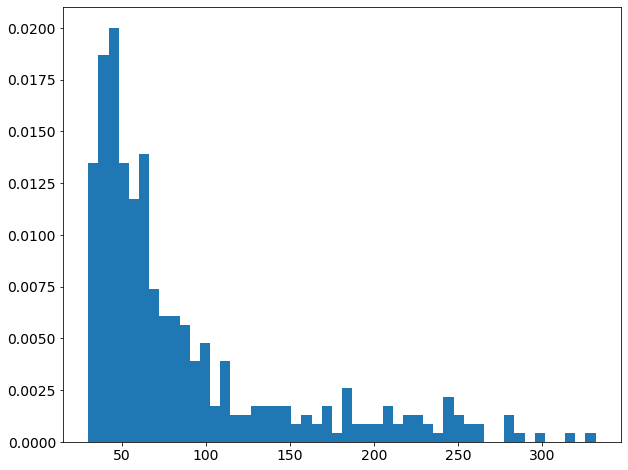

In [11]:
#debugging nuTauRatio plots 
#trying to just do magnitude first 

fig, ax = plt.subplots(figsize=(10,8))
#bin_heights, bin_borders, _ = plt.hist(df.tau_1_matched_decay_neutrino_p, bins=50, density=True, label='histogram')
bin_heights, bin_borders, _ = plt.hist(df.tau_0_p_p, bins=50, density=True, label='histogram')

In [12]:
#this is for manually calculating the area under the curve, only if you deem it necessary 
def michael_had_nuTauAngle(x):
    return log_normal(x, p0=0.0787, p1=0.779, p2 = 0.00219, p3=0.0215)

def michael_had_nuTauRatio(x):
    return fit_function(x, p0=-0.802,p1=-0.712, p2=-0.464, p3=-1.38, p4=-1.590)

In [13]:
#this is the main method for fitting the histogram 
def calculate_hist(pdf, pdf_name, func, m_params, m_integral, bins, integralCheck=michael_had_nuTauRatio):
    print("number of entries: " + str(len(pdf)))

    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, density=True, label='histogram')

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    print("bin width: " + str(np.diff(bin_borders)[0]))
    
    michael_integral, error = integrate.quad(integralCheck, a=bins[0], b=bins[-1])
    print('michael integral): ' + str(michael_integral))
    
    popt, _ = curve_fit(func, bin_centers, bin_heights, maxfev=1000000, p0=m_params)
    #print("Parameters found for best fit:")
    #print("p0: {:.2f}, p1: {:.2f}, p2: {:.2f}, p3: {:.2f}".format(popt[0],popt[1],popt[2],popt[3]))

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit')
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16)
    
    #plt.savefig('/Users/ibhallaladd/Desktop/'+ pdf_name + '_test.root')

    print("Michael's Params | " + str(m_params))
    print("My Params        | " + str(popt))


number of entries: 381
bin width: 0.004729729729729729
michael integral): 0.019574428788923074
Michael's Params | [0.106, 1, 0.00241, 0.0165]
My Params        | [2.11213989e+01 9.05195634e-01 3.43142777e-03 1.98262495e-02]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


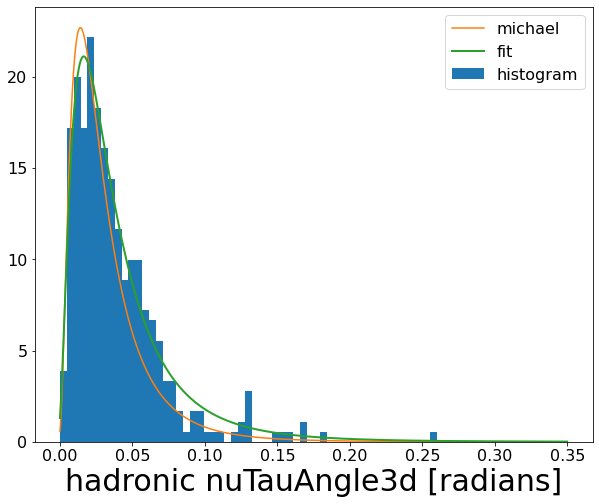

In [14]:
nuTauAngle_had = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))
calculate_hist(nuTauAngle_had,"hadronic nuTauAngle3d [radians]", log_normal, m_params=[0.106, 1, 0.00241, 0.0165], m_integral=0.00467, bins=np.linspace(0,0.35,75))


number of entries: 381
bin width: 0.004054054054054054
michael integral): 0.015376167804800434
Michael's Params | [0.10589, 1, 0.002434, 0.0166]
My Params        | [2.12402018e+01 1.77452973e+00 1.28359717e-02 3.10029977e-02]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


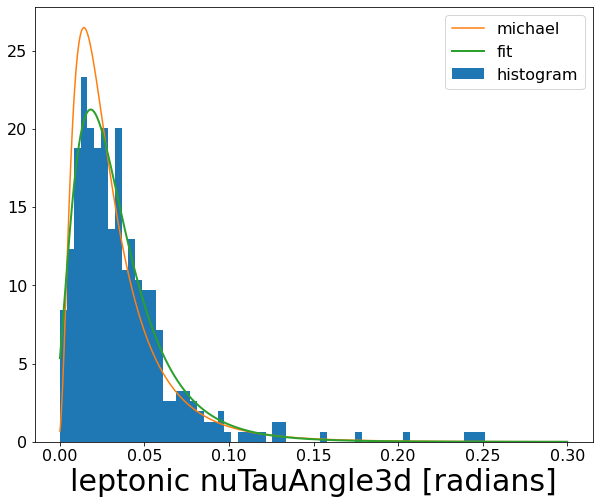

In [15]:
nuTauAngle_lep = np.arccos(((df.tau_1_p_x*df.tau_1_matched_decay_neutrino_p_x)+
                        (df.tau_1_p_y*df.tau_1_matched_decay_neutrino_p_y)+
                        (df.tau_1_p_z*df.tau_1_matched_decay_neutrino_p_z)) 
                               / (df.tau_1_p_p*df.tau_1_matched_decay_neutrino_p_p))
calculate_hist(nuTauAngle_lep,"leptonic nuTauAngle3d [radians]", log_normal, m_params=[0.10589, 1, 0.002434, 0.0166,], m_integral=0.004,bins=np.linspace(0,0.3,75))

number of entries: 381
bin width: 0.036734693877551024
michael integral): 0.09092464043468058
Michael's Params | [0.948, -2.51, 1.13]
My Params        | [1.38468292 0.29673147 0.34796364]


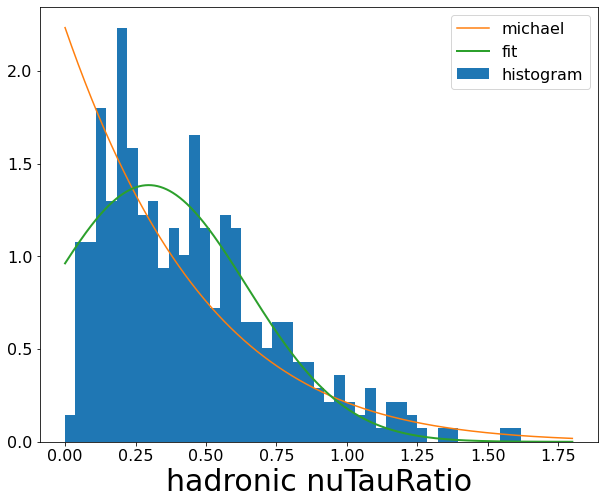

In [16]:
nuTauRatio_had = df.tau_0_matched_decay_neutrino_p/df.tau_0_p
calculate_hist(nuTauRatio_had,"hadronic nuTauRatio", fit_nuTau, m_params=[0.948, -2.51, 1.13], m_integral=0.036, bins=np.linspace(0,1.8, 50))

#from slide 4: m_params=[-0.802,-0.712, -0.464, -1.38, -1.59]
#from slide 5: m_params=[0.0659, 1.6776, 0.45497, 0.47949, 0.529]

number of entries: 381
bin width: 0.10204081632653061
michael integral): 0.09991208537881134
Michael's Params | [-0.802, -0.712, -0.464, -1.38, -1.59]
My Params        | [-2.14273679e+08 -7.45215811e+00 -1.33560405e+00  3.62012691e+00
 -3.86833940e+00]


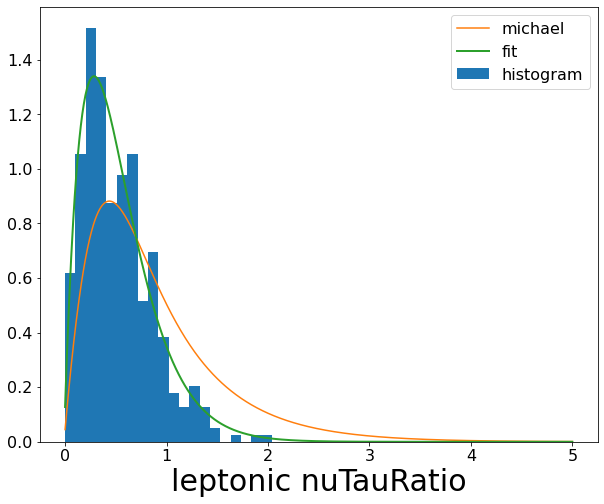

In [17]:
nuTauRatio_lep = df.tau_1_matched_decay_neutrino_p/df.tau_1_p_p
calculate_hist(nuTauRatio_lep,"leptonic nuTauRatio", fit_function, m_params=[-0.802,-0.712, -0.464, -1.38, -1.59], m_integral=0.1, bins=np.linspace(0,5, 50))


(1.35, 1.55)

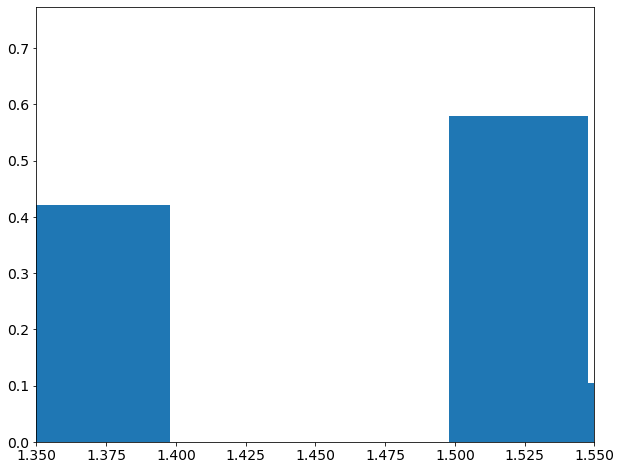

In [18]:
nuTauRatio_lep = df.tau_1_matched_decay_neutrino_p/df.tau_1_p_p

fig, ax = plt.subplots(figsize=(10,8))
bin_heights, bin_borders, _ = plt.hist(df.tau_0_allTrk_eta, bins=100, density=True, label='histogram')

#np.linspace(0,5, 50)
plt.xlim(1.35, 1.55)
#1.37, 1.52


In [20]:
def pdf_to_ROOT():
    ##THIS DOES NOT WORK, TROUBLESHOOTING ROOT BEFORE I CAN FIX THIS
    gROOT.ProcessLine(
    "struct MyStruct {\
       Int_t     fMyInt1;\
       Int_t     fMyInt2;\
       Int_t     fMyInt3;\
       Char_t    fMyCode[4];\
    };" );

    from ROOT import MyStruct
    mystruct = MyStruct()

    f = TFile( 'mytree.root', 'RECREATE' )
    tree = TTree( 'T', 'Just A Tree' )
    tree.Branch( 'myints', mystruct, 'MyInt1/I:MyInt2:MyInt3' )
    tree.Branch( 'mycode', AddressOf( mystruct, 'fMyCode' ), 'MyCode/C' )

    for i in range(10):
       mystruct.fMyInt1   = i
       mystruct.fMyInt2   = i*i
       mystruct.fMyInt3   = i*i*i
       mystruct.fMyCode   = "%03d" % i      # note string assignment

       tree.Fill()

    f.Write()
    f.Close()